# Getting the data ready

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)

print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [2]:
import numpy as np

X, y = np.array(mnist["data"]), np.array(mnist["target"]).astype(np.uint8)

print(X, '\n\n', y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

 [5 0 4 ... 4 5 6]


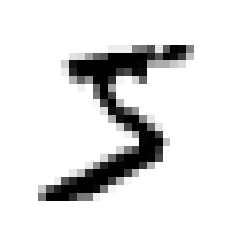

This number is a: 5


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

first_digit = X[0]
first_digit_label = y[0]
first_digit_image = first_digit.reshape(28, 28) 

plt.imshow(first_digit_image, cmap="binary") 
plt.axis("off")
plt.show()

print("This number is a:", first_digit_label)

### Separating the sets (they are conveniently sorted)

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a 7 classifier (binary)

In [5]:
### MODEL USED: Stochastic Gradient Descent

from sklearn.linear_model import SGDClassifier

y_train_is_seven = (y_train == 7)
y_test_is_seven = (y_test == 7)

sgd = SGDClassifier(random_state = 42)
sgd.fit(X_train, y_train_is_seven)

SGDClassifier(random_state=42)

In [6]:
index = 0

for i in range(len(y_train_is_seven)):
    if y_train_is_seven[i]:
        index = i
        break
        
if sgd.predict([X_train[index]]):
    print("Yay!")
else:
    print("Nay!")

Yay!


### Evaluating the current model

In [7]:
### CROSS-VALIDATION

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.base import clone

"""skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

results = []
for train_indexes, val_indexes in skfolds.split(X_train, y_train_is_seven):
    X_train_fold, y_train_fold = X_train[train_indexes], y_train[train_indexes]
    X_val_fold, y_val_fold = X_train[val_indexes], y_train[val_indexes]
    
    sgd_clone = clone(sgd)
    sgd_clone.fit(X_train_fold, y_train_fold)
    predictions = sgd_clone.predict(X_val_fold)
    
    right_count = sum(predictions == y_val_fold)
    results.append(right_count / len(y_val_fold))
    
    print(len(results))
    
print(results)
print("Mean:", sum(results) / len(results))"""

cross_val_score(sgd, X_train, y_train_is_seven, cv=3, scoring="accuracy")

array([0.98105, 0.9735 , 0.95335])

#### But there's a problem... The model could be guessing that a lot of the 7's are not 7 in order to get good results, since there's about 10% of 7's in the train set. Even a model that always predicts a number as not being 7 would have an accuracy of close to 90%.

In [8]:
from sklearn.model_selection import cross_val_predict

cv_predictions = cross_val_predict(sgd, X_train, y_train_is_seven, cv=3)
cv_predictions

array([False, False, False, ..., False, False, False])

In [9]:
from sklearn.metrics import confusion_matrix  # Displays false-positives and false-negatives

cm = confusion_matrix(y_train_is_seven, cv_predictions)  # 1154 false-positives and 688 false negatives
cm

array([[52581,  1154],
       [  688,  5577]], dtype=int64)

In [10]:
precision   = cm[1, 1] / (cm[0, 1] + cm[1, 1])  # a low value means the model overshoots with the amount of 7's
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])  # a low value means the model undershoots with the amount of 7's

# Sensitivity is usually refered as recall

print(precision, sensitivity)

0.8285544495617293 0.8901835594573024


#### Conclusion: the model isn't that accurate afterall. Also, is overshoots 7's more than it undershoots 7's, and the goal is to make them even. To do this, the model's threshold needs to be adjusted

In [11]:
y_scores_sgd = cross_val_predict(sgd, X_train, y_train_is_seven, cv=3, method="decision_function")

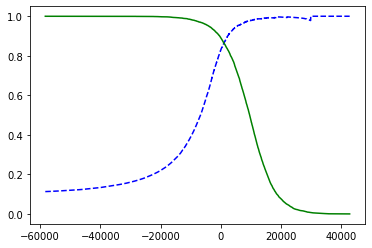

Optimal threshold: 1016


In [12]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_is_seven, y_scores_sgd)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.show()

optimal_threshold = round(thresholds[np.argmax(precisions == recalls)])
print("Optimal threshold:", optimal_threshold)

### Testing with the optimized threshold

In [13]:
cv_optimal_predictions = y_scores_sgd >= optimal_threshold
cv_optimal_predictions

array([False, False, False, ..., False, False, False])

In [14]:
cm_op = confusion_matrix(y_train_is_seven, cv_optimal_predictions)  # 846 false-positives and 847 false-negatives
cm_op

array([[52889,   846],
       [  847,  5418]], dtype=int64)

In [15]:
precision_op   = cm_op[1, 1] / (cm_op[0, 1] + cm_op[1, 1])
sensitivity_op = cm_op[1, 1] / (cm_op[1, 0] + cm_op[1, 1])

print(precision_op, sensitivity_op)  # Great! This is the most balanced version of this model

0.8649425287356322 0.864804469273743


# Training a better 7 classifier (binary)

In [16]:
### MODEL USED: Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42) 
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_is_seven, cv = 3, method="predict_proba")

y_probas_forest  # array of lists: list[0] = prob_negative_cls, list[1] = prob_positive_cls

array([[0.98, 0.02],
       [1.  , 0.  ],
       [0.89, 0.11],
       ...,
       [0.99, 0.01],
       [1.  , 0.  ],
       [0.98, 0.02]])

In [17]:
y_scores_forest = y_probas_forest[:, 1]
y_scores_forest.shape

(60000,)

### Comparing both models

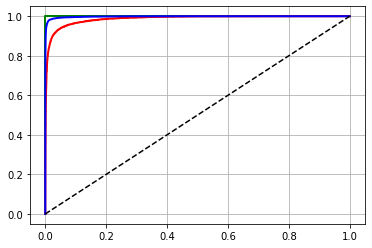

In [18]:
### ROC curve: recall x false-positive rate (true-positive rate x false-positive rate)

from sklearn.metrics import roc_curve
    
fpr_sgd, tpr_sgd, thresh_sgd = roc_curve(y_train_is_seven, y_scores_sgd)      # SGD
fpr_for, tpr_for, thresh_for = roc_curve(y_train_is_seven, y_scores_forest)   # Rnd Forest
fpr_per, tpr_per, thresh_per = roc_curve(y_train_is_seven, y_train_is_seven)  # Perfect

plt.plot(fpr_per, tpr_per, "g-", linewidth=2, label=None) # Control
plt.plot(fpr_sgd, tpr_sgd, "r-", linewidth=2, label=None) # first model - Good
plt.plot(fpr_for, tpr_for, "b-", linewidth=2, label=None) # second model - Close to perfect!

plt.plot([0, 1], [0, 1], 'k--')  # Represents a totally random model (guesses right as much as guesses wrong)

plt.grid(b=True)
#plt.figure(figsize=(10, 10))

plt.show()

# Training a 10-digit classifier

Options: 
- Use a model that natively does the multiclassification (e.g. the previous RandomForest)
- Use 10 binary classifiers, one for each digit (one-versus-the-rest / one-versus-all)
- Use (10-1) * 10/2 = 45 binary classifiers, each one responsible for comparing if a number is X or Y (one-versus-one)

In [19]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler() 
scaler.fit(X_train.astype(np.float64))

X_train_scaled = scaler.transform(X_train.astype(np.float64))
first_digit_scaled = scaler.transform([first_digit.astype(np.float64)])

In [20]:
import pandas

pandas.DataFrame(first_digit_scaled)

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.033171,-0.022463,-0.016069,-0.011432,-0.009007,-0.00577,0.0,0.0,0.0,0.0


### Multiclass by nature

In [21]:
forest_clf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [22]:
prediction = forest_clf.predict(first_digit_scaled)  # first_digit = 5 as seen earlier
prediction  # right!

array([5], dtype=uint8)

In [23]:
forest_clf.predict_proba(first_digit_scaled)

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

### One versus all

In [24]:
### IMPLICIT: sklearn already identifies that OvR is the better option for a SGDClassifier

# It's possible to change this to OvO for SGDClassifier using the function sklearn.multiclass.OneVsOneClassifier

sgd.fit(X_train_scaled, y_train)

SGDClassifier(random_state=42)

In [25]:
prediction = sgd.predict(first_digit_scaled)  # again, 5
prediction  # right!

array([5], dtype=uint8)

In [26]:
sgd.decision_function(first_digit_scaled)

array([[-1.12757674e+03, -9.49187954e+02, -4.17629163e+02,
        -1.32423197e+01, -1.63698367e+03,  6.96355792e-01,
        -1.70774018e+03, -7.09325794e+02, -5.23366898e+01,
        -5.88154757e+02]])

### One versus one

In [27]:
### IMPLICT: sklearn already identifies that OvO is the better option for SVC (Support Vector Machine Classifier)

# It's possible to change this to OvR for SVC using the function sklearn.multiclass.OneVsRestClassifier

from sklearn.svm import SVC

svm = SVC()

svm.fit(X_train_scaled, y_train)

SVC()

In [28]:
prediction = svm.predict(first_digit_scaled)  # again, 5
prediction  # right!

array([5], dtype=uint8)

In [29]:
svm.decision_function(first_digit_scaled)

array([[ 2.75523198,  0.72151155,  7.18864415,  8.30206541, -0.30060064,
         9.3051746 ,  1.72946953,  5.03043793,  3.8171665 ,  6.13068855]])

### Comparing the models (actually, just checking if rnd_forest overfitted or not. Checking everything would take too long)

In [30]:
scores = cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")  

# Checking for accuracy now is not a problem, since the job now is much more complex

In [31]:
print(scores)
print(scores.mean(), scores.std())  # didn't overfit :)

[0.96445 0.96255 0.96645]
0.9644833333333334 0.0015923427883328307


# Enhancements

### Enhancing the train set: making it bigger

In [33]:
#from scipy.ndimage.interpolation import shift

X_train_scaled_old = X_train_scaled
X_train_scaled_old.shape

(60000, 784)

In [76]:
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [77]:
X_train_augmented.shape  # 5x bigger...

(300000, 784)

In [78]:
scaler = StandardScaler()

X_train_aug_scaled = scaler.fit_transform(X_train_augmented.astype(np.float64))

In [79]:
forest_clf.fit(X_train_aug_scaled, y_train_augmented)

RandomForestClassifier(random_state=42)

In [82]:
scores_aug = cross_val_score(forest_clf, X_train_aug_scaled, y_train_augmented, cv=3, scoring="accuracy")  

In [85]:
scores_aug
print(scores_aug.mean(), scores_aug.std())  # it took a lot longer and the result was even worse...

0.9652433333333333 0.010920245214991992
